In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import scipy.stats as stat

In [3]:
df_train = pd.read_json('/Users/sami/Desktop/MS-ASL/meta/cleaned/MSASL_train_clean.json').drop(columns=['available', 'text', 'org_text', 'file'])
df_val = pd.read_json('/Users/sami/Desktop/MS-ASL/meta/cleaned/MSASL_val_clean.json').drop(columns=['available', 'text', 'org_text', 'file'])
df_test = pd.read_json('/Users/sami/Desktop/MS-ASL/meta/cleaned/MSASL_test_clean.json').drop(columns=['available', 'text', 'org_text', 'file'])

Minimum: 9
Mean: 24.41


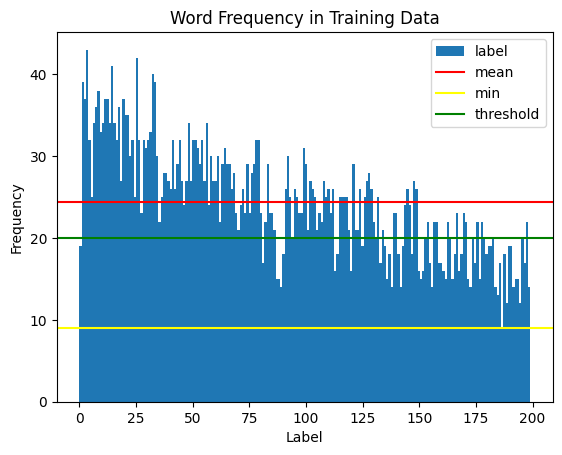

In [4]:
df_train['label'].loc[df_train.label <200].plot(kind='hist',bins=200)
mean_occ = np.mean(df_train.groupby(df_train.label.loc[df_train.label <200]).agg({'label':'count'}))
min_occ = np.min(df_train.groupby(df_train.label.loc[df_train.label <200]).agg({'label':'count'}))
plt.axhline(mean_occ, color='red', label='mean')
plt.axhline(min_occ, color='yellow', label='min')
plt.axhline(20, c='green', label='threshold')
plt.xlabel('Label')
plt.legend()
plt.title('Word Frequency in Training Data')
print('Minimum: {}'.format(min_occ))
print('Mean: {}'.format(mean_occ))
plt.show()

# Wir wollen unbedingt einen möglichst gleich verteilten datensatz haben. Aus Ressourcen Gründen können wir nicht alles herunterladen. Ziel wäre also 100 Begriffe zu trainieren
# Idee: Wir legen einen threshold von 20 fest, also 20 Videos pro Klasse und schauen dann, ob es 100 Klassen in MSASL 200 gibt die diesen threshold überbieten können; für diese 100 Labels entscheiden wir uns und nehmen dann randomisiert 20 videos pro label
# Wir vernachlässigen erstmal val und test, weil da die verteilung keine große Rolle spielt. Wir wollen nur sicherstellen, dass jedes trainierte label, sowohl in val als auch im testdatensatz mindestens einmal vorkommt

In [5]:
df_train_200 = df_train.loc[df_train.label <200]
df_train_200_label_count = df_train_200.groupby('label').agg({'label':'count'})
df_train_200_label_count_30_or_more = df_train_200_label_count.loc[df_train_200_label_count.label >=30]
print('There are {} distinct labels with 30 or more occ.'.format(len(df_train_200_label_count_30_or_more)))
df_train_200_label_count_30_or_more.head()

There are 45 distinct labels with 30 or more occ.


,label
label,
1,39
2,37
3,43
4,32
6,34


In [6]:
df_train_reduced = df_train.loc[df_train.label.isin(df_train_200_label_count_30_or_more.index)]
df_train_reduced

,clean_text,start_time,signer_id,signer,start,end,label,height,fps,end_time,url,box,width
37,want,385.765,6,-1,9594,9751,8,358,24.870,392.077,https://www.youtube.com/watch?v=jQb9NL9_S6U,"[0.008866041898727, 0.11897420883178701, 0.843...",640
40,must,433.452,6,-1,10780,10870,29,358,24.870,437.071,https://www.youtube.com/watch?v=jQb9NL9_S6U,"[0.0, 0.081183195114135, 0.850859522819519, 0....",640
47,teacher,13.995,144,-1,419,464,2,360,29.940,15.498,https://www.youtube.com/watch?v=_HOx2QkkTsg,"[0.045998364686965006, 0.037116646766662, 1.0,...",480
48,teacher,15.498,144,-1,464,510,2,360,29.940,17.034,https://www.youtube.com/watch?v=_HOx2QkkTsg,"[0.045998364686965006, 0.037116646766662, 1.0,...",480
49,deaf,0.000,38,52,0,107,9,270,29.917,3.577,www.youtube.com/watch?v=IgT0jDp56ZM,"[0.033616244792938, 0.27784588932991, 1.0, 0.7...",480
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12750,white,120.721,32,17,3618,3737,13,360,29.970,124.691,https://www.youtube.com/watch?v=fNg_sJ9f8EI,"[0.011435627937316001, 0.246980562806129, 1.0,...",640
12751,man,126.059,32,17,3778,3897,58,360,29.970,130.030,https://www.youtube.com/watch?v=fNg_sJ9f8EI,"[0.014650225639343002, 0.24572466313838903, 1....",640
12754,blue,151.184,32,17,4531,4694,64,360,29.970,156.623,https://www.youtube.com/watch?v=fNg_sJ9f8EI,"[0.018003463745117, 0.25626096129417403, 1.0, ...",640
12757,no,180.514,32,17,5410,5529,4,360,29.970,184.484,https://www.youtube.com/watch?v=fNg_sJ9f8EI,"[0.019318848848342, 0.275617480278015, 1.0, 0....",640


45


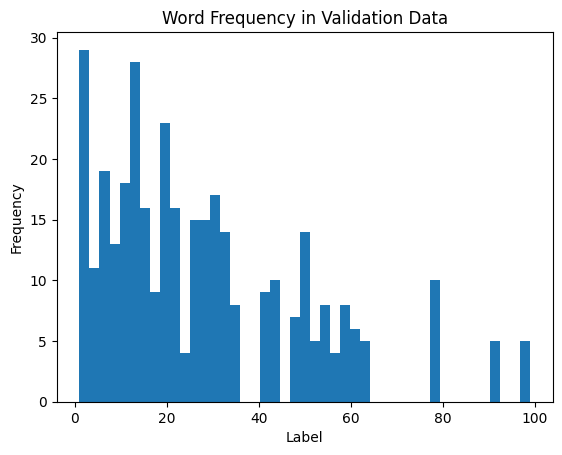

In [7]:
df_val['label'].loc[df_val.label.isin(df_train_200_label_count_30_or_more.index)].plot(kind='hist', bins=45)
df_val_reduced = df_val.loc[df_val.label.isin(df_train_200_label_count_30_or_more.index)]
unique_lab_in_val = df_val_reduced.groupby('label').agg({'label':'count'})
print(len(unique_lab_in_val.index))
plt.xlabel('Label')
plt.title('Word Frequency in Validation Data')
plt.show()

45


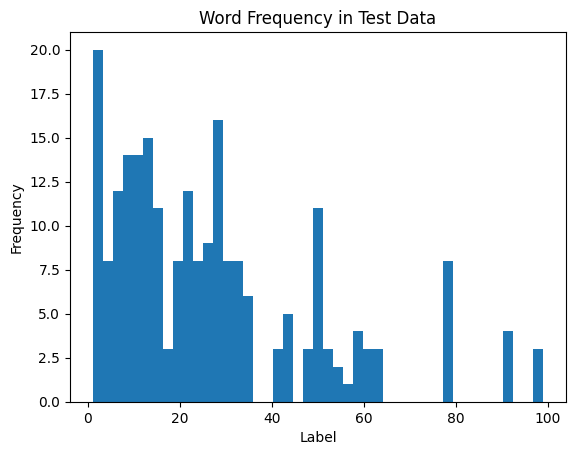

In [8]:
df_test['label'].loc[df_test.label.isin(df_train_200_label_count_30_or_more.index)].plot(kind='hist', bins=45)
df_test_reduced = df_test.loc[df_test.label.isin(df_train_200_label_count_30_or_more.index)]
unique_lab_in_test = df_test_reduced.groupby('label').agg({'label':'count'})
print(len(unique_lab_in_test.index))
plt.xlabel('Label')
plt.title('Word Frequency in Test Data')

plt.show()

In [9]:
### Wir wollen nur die ersten 100 Labels verwenden (MSASL-100)
### Wir verwenden beim training 80 Videos pro Label: 100*100 = 10000
### Wir verwenden beim validieren 15 Videos pro Label: 15*100 = 1500
### Wir verwenden beim testen 15 Videos pro Label: 15*100 = 1500
### Wir entscheiden uns pro Klasse randomisiert für die videos -> keinen bestimmten Bias